In [10]:
# Run new libraries
import pandas as pd
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import Vectors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

# Load the data
df = pd.read_csv("Resources/merged_data_4.csv")
df.head()

,Title,Release Date,Team,Rating,Number of Reviews,Plays,Playing,rank,platform,genre,publisher,na_sales,eu_sales,jp_sales,other_sales,global_sales
0,Elden Ring,"Feb 25, 2022","['Bandai Namco Entertainment', 'FromSoftware']",4.5,3.9K,17K,3.8K,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Hades,"Dec 10, 2019",['Supergiant Games'],4.3,2.9K,21K,3.2K,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,The Legend of Zelda: Breath of the Wild,"Mar 03, 2017","['Nintendo', 'Nintendo EPD Production Group No...",4.4,4.3K,30K,2.5K,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Undertale,"Sep 15, 2015","['tobyfox', '8-4']",4.2,3.5K,28K,679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Hollow Knight,"Feb 24, 2017",['Team Cherry'],4.4,3K,21K,2.4K,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<h2 style="font-size: 24px;">Using ScalarStandard:</h2>
Determining success of a video game based on Global Sales, Ratings, and Number of Reviews

Whittle down the columns

In [11]:
# Drop the non-beneficial ID columns, 'Title'.
df= df.drop(columns=['Title', 'Release Date', 'Team', 'Plays', 'Playing', 'rank', 'platform', 'publisher', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales'])
df.head()

,Rating,Number of Reviews,genre,global_sales
0,4.5,3.9K,NaN,NaN
1,4.3,2.9K,NaN,NaN
2,4.4,4.3K,NaN,NaN
3,4.2,3.5K,NaN,NaN
4,4.4,3K,NaN,NaN


Convert the K's to integers

In [12]:
# Check and convert 'Number of Reviews' values from string to float
def convert_to_float(x):
    if isinstance(x, float):
        return x
    else:
        return float(x[:-1]) * 1000 if x[-1] == 'K' else float(x)
    
df['Number of Reviews'] = df['Number of Reviews'].apply(convert_to_float)
df

,Rating,Number of Reviews,genre,global_sales
0,4.5,3900.0,NaN,NaN
1,4.3,2900.0,NaN,NaN
2,4.4,4300.0,NaN,NaN
3,4.2,3500.0,NaN,NaN
4,4.4,3000.0,NaN,NaN
...,...,...,...,...
12141,NaN,NaN,Action,0.01
12142,NaN,NaN,Role-Playing,0.01
12143,NaN,NaN,Simulation,0.01
12144,NaN,NaN,Platform,0.01


Drop all NaN values

In [29]:
# Drop all NaN
df.dropna(inplace=True)
df

,Rating,Number of Reviews,genre,global_sales
5,4.3,2300.0,Misc,9.20
12,4.2,2900.0,Action,4.45
13,4.4,2900.0,Shooter,2.10
14,4.5,3400.0,Action,2.38
22,4.1,2100.0,Action,1.47
...,...,...,...,...
1089,3.1,133.0,Platform,0.25
1090,3.8,211.0,Fighting,0.88
1094,3.2,94.0,Adventure,0.17
1096,3.7,210.0,Role-Playing,1.78


In [30]:
unique_genre= df['genre'].nunique()
print(unique_genre)

each_genre= df['genre'].unique()
print(each_genre)

pop_genre= df['genre'].value_counts()
print(pop_genre)

12
['Misc' 'Action' 'Shooter' 'Role-Playing' 'Platform' 'Adventure' 'Sports'
 'Racing' 'Strategy' 'Puzzle' 'Simulation' 'Fighting']
Action          129
Role-Playing     82
Platform         75
Shooter          60
Adventure        30
Fighting         19
Racing           13
Strategy         11
Puzzle           11
Simulation       11
Misc             10
Sports            7
Name: genre, dtype: int64


In [31]:
# Find the stats for global sales so we can define 'success'
print("Minimum global sales:", df['global_sales'].min())
print("Maximum global sales:", df['global_sales'].max())
print("Average global sales:", df['global_sales'].mean())


Minimum global sales: 0.01
Maximum global sales: 82.74
Average global sales: 3.3002620087336245


In [39]:
# Find the stats for global sales grouped by genre
genre_sales = df.groupby('genre')['global_sales'].agg(['min', 'max', 'mean']).sort_values(by='mean', ascending=False)
print(genre_sales)


               min    max       mean
genre                               
Sports        0.23  82.74  13.964286
Racing        1.10  35.82   9.036923
Puzzle        0.11  30.26   5.091818
Platform      0.03  40.24   4.293067
Shooter       0.06  14.76   3.969833
Action        0.02  21.40   2.834264
Fighting      0.03  13.04   2.815789
Misc          0.26   9.20   2.695000
Simulation    0.01   9.09   2.584545
Role-Playing  0.01   9.72   2.034268
Strategy      0.26   1.69   1.028182
Adventure     0.02   5.55   0.916333


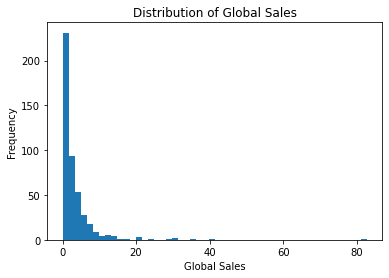

In [34]:
import matplotlib.pyplot as plt

# Plot histogram of global sales
plt.hist(df['global_sales'], bins=50)
plt.xlabel('Global Sales')
plt.ylabel('Frequency')
plt.title('Distribution of Global Sales')
plt.show()

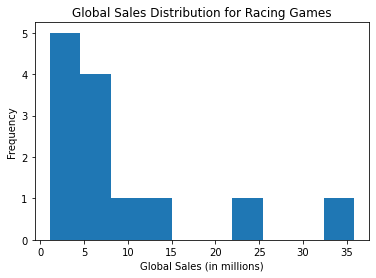

In [37]:
import matplotlib.pyplot as plt

# Filter dataframe to only include rows with genre = 'Action'
racing_df = df[df['genre'] == 'Racing']

# Plot global_sales distribution for Action games
plt.hist(racing_df['global_sales'], bins=10)
plt.title('Global Sales Distribution for Racing Games')
plt.xlabel('Global Sales (in millions)')
plt.ylabel('Frequency')
plt.show()


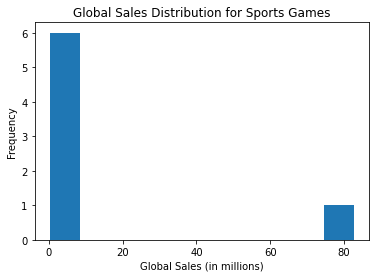

In [36]:
# Filter dataframe to only include rows with genre = 'Action'
sports_df = df[df['genre'] == 'Sports']

# Plot global_sales distribution for Action games
plt.hist(sports_df['global_sales'], bins=10)
plt.title('Global Sales Distribution for Sports Games')
plt.xlabel('Global Sales (in millions)')
plt.ylabel('Frequency')
plt.show()

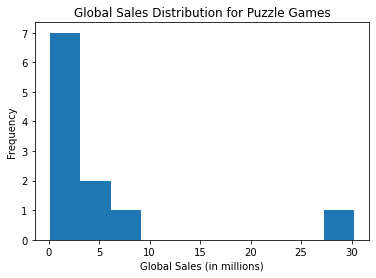

In [38]:
# Filter dataframe to only include rows with genre = 'Action'
puzzle_df = df[df['genre'] == 'Puzzle']

# Plot global_sales distribution for Action games
plt.hist(puzzle_df['global_sales'], bins=10)
plt.title('Global Sales Distribution for Puzzle Games')
plt.xlabel('Global Sales (in millions)')
plt.ylabel('Frequency')
plt.show()

In [41]:
# Define Success of global_sales
df['Success'] = (df['global_sales'] > 3.5).astype(int)

print(df)

      Rating  Number of Reviews         genre  global_sales  Success
5        4.3             2300.0          Misc          9.20        1
12       4.2             2900.0        Action          4.45        1
13       4.4             2900.0       Shooter          2.10        0
14       4.5             3400.0        Action          2.38        0
22       4.1             2100.0        Action          1.47        0
...      ...                ...           ...           ...      ...
1089     3.1              133.0      Platform          0.25        0
1090     3.8              211.0      Fighting          0.88        0
1094     3.2               94.0     Adventure          0.17        0
1096     3.7              210.0  Role-Playing          1.78        0
1098     2.8              184.0        Action          1.32        0

[458 rows x 5 columns]


In [44]:
# Drop genre
df.drop(columns=['genre'], inplace=True)

In [45]:
# Create features and target arrays
X= df.drop('Success', axis=1)
y= df['Success']

# Split the preprocessed data into a training and testing database
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [46]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [47]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train.iloc[0])
hidden_nodes_layer1 =  600
hidden_nodes_layer2 = 500

nn = tf.keras.models.Sequential()

# First hidden "relu" layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden "relu" layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output "sigmoid" layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 600)               2400      
                                                                 
 dense_1 (Dense)             (None, 500)               300500    
                                                                 
 dense_2 (Dense)             (None, 1)                 501       
                                                                 
Total params: 303,401
Trainable params: 303,401
Non-trainable params: 0
_________________________________________________________________


In [48]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [49]:
# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=100)

Epoch 1/100
11/11 [==============================] - 4s 12ms/step - loss: 0.4958 - accuracy: 0.8163
Epoch 2/100
11/11 [==============================] - 0s 5ms/step - loss: 0.2431 - accuracy: 0.8980
Epoch 3/100
11/11 [==============================] - 0s 7ms/step - loss: 0.1421 - accuracy: 0.9359
Epoch 4/100
11/11 [==============================] - 0s 14ms/step - loss: 0.0913 - accuracy: 0.9708
Epoch 5/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0622 - accuracy: 0.9883
Epoch 6/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0460 - accuracy: 0.9883
Epoch 7/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0401 - accuracy: 0.9913
Epoch 8/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0314 - accuracy: 0.9971
Epoch 9/100
11/11 [==============================] - 0s 15ms/step - loss: 0.0277 - accuracy: 0.9971
Epoch 10/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0277 - accuracy: 0.9913
Epoch 

In [51]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

4/4 - 0s - loss: 0.0227 - accuracy: 0.9913 - 42ms/epoch - 11ms/step
Loss: 0.022697536274790764, Accuracy: 0.991304337978363
